# Example of image capturing and processing for uEye UI-1580-SE-C-HQ

This script is a working principle to
- read/set camera options
- capturing image
- postprocess the image
- capture arUco Marker (6x6 -250)

According to this link (https://en.ids-imaging.com/manuals/ids-peak/ids-peak-user-manual/2.0.0/en/ueye-intro.html)
uEye Transport Layer must be installed additionally to IDS Peak (including IDS Peak IPL) and IDS Software Suite. The transport layer can be selected as additional option while installing IDS peak!

In [1]:
from ids_peak import ids_peak
from ids_peak import ids_peak_ipl_extension
import ids_peak_ipl.ids_peak_ipl
from ids_peak_ipl.ids_peak_ipl import Image, PixelFormatName_BGR8, ConversionMode_HighQuality,ConversionMode_Fast
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Presets
Set arUco Dictionary, chose camera and initialize Library

In [2]:
arucos = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
cam = 1

#setup ids_peak
ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
print(device_manager)

<ids_peak.ids_peak.DeviceManager; proxy of <Swig Object of type 'peak::DeviceManager *' at 0x000001A58706F270> >


## Camera settings

0: GV-580xSE-C (IDS GigE Vision @ "Ethernet" (D8-BB-C1-93-B8-45); IDS GenICam Producer (GEVK)v.1.11.0.1)
1: UI158xSE-C (IDS uEye; IDS GenICam Producer (uEye)v.1.11.0.1)
Model Name: UI158xSE-C
User ID: (unknown)
Sensor Name: (unknown)
Max. resolution (w x h): 2560 x 1920
PayLoadSize: 4915200
num buffers required: 2
Closing Device Manager
()
None
()


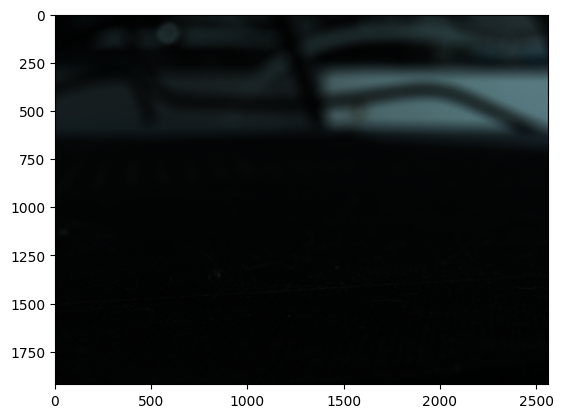

In [3]:
try: 
    device_manager.Update()
    if device_manager.Devices().empty():
        print("no devices found")
    else:
        for i, device in enumerate(device_manager.Devices()):
            print(str(i) + ": " + device.ModelName() + " ("
                  + device.ParentInterface().DisplayName() + "; "
                  + device.ParentInterface().ParentSystem().DisplayName() + "v."
                  + device.ParentInterface().ParentSystem().Version() + ")")
        # open first device
        device = device_manager.Devices()[cam].OpenDevice(ids_peak.DeviceAccessType_Control)

        # get the rmeote device node map
        nodemap_remote_device = device.RemoteDevice().NodeMaps()[0]
        # print model name and user ID
        print("Model Name: " + nodemap_remote_device.FindNode("DeviceModelName").Value())
        try:
            print("User ID: " + nodemap_remote_device.FindNode("DeviceUserID").Value())
        except ids_peak.Exception:
            print("User ID: (unknown)")
            
        # print sensor information, not knowing if device has the node "SensorName"
        try:
            print("Sensor Name: " + nodemap_remote_device.FindNode("SensorName").Value())
        except ids_peak.Exception:
            print("Sensor Name: " + "(unknown)")
        
        # print resolution
        try:
            print("Max. resolution (w x h): "
                  + str(nodemap_remote_device.FindNode("WidthMax").Value()) + " x "
                  + str(nodemap_remote_device.FindNode("HeightMax").Value()))
        except ids_peak.Exception:
            print("Max. resolution (w x h): (unknown)")
            
        dataStreams = device.DataStreams()
        if dataStreams.empty():
            print("dataStreams error ... not described which error") 
        dataStream = device.DataStreams()[0].OpenDataStream();
        nodemapDataStream = dataStream.NodeMaps()[0];
        try:
            if dataStream:
                # Flush queue and prepare all buffers for revoking
                dataStream.Flush(ids_peak.DataStreamFlushMode_DiscardAll)
                 
                # Clear all old buffers
                for buffer in dataStream.AnnouncedBuffers():
                   dataStream.RevokeBuffer(buffer)
                payload_size = nodemap_remote_device.FindNode("PayloadSize").Value()
                print(f"PayLoadSize: {payload_size}")
                # Get number of minimum required buffers
                num_buffers_min_required = dataStream.NumBuffersAnnouncedMinRequired()
                print(f"num buffers required: {num_buffers_min_required}")
                
                # Alloc buffers
                for count in range(num_buffers_min_required):
                    buffer = dataStream.AllocAndAnnounceBuffer(payload_size)
                    dataStream.QueueBuffer(buffer)
                
        except Exception as e:
            print(f"Exception while buffer allocating: {str(e)}")
        
        # start acquisition
        try:
            dataStream.StartAcquisition(ids_peak.AcquisitionStartMode_Default, ids_peak.DataStream.INFINITE_NUMBER)
            nodemap_remote_device.FindNode("TLParamsLocked").SetValue(1)
            nodemap_remote_device.FindNode("AcquisitionStart").Execute()
        except Exception as e:
            print(str(e))
        
        # receive image
        try: 
            buffer = dataStream.WaitForFinishedBuffer(5000)
            image = ids_peak_ipl_extension.BufferToImage(buffer)
            image = image.ConvertTo(PixelFormatName_BGR8, ConversionMode_Fast)
            dataStream.QueueBuffer(buffer)
        except Exception as e:
            print(str(e))
        # convert image to numpy array
        img = np.copy(image.get_numpy_3D())
        plt.imshow(img)
except Exception as e:
    print("Exception: " + str(e))
finally:
    print("Closing Device Manager")
    ids_peak.Library.Close()


(corners, ids, rejected) = cv2.aruco.detectMarkers(img, arucos,)
print(corners)
print(ids)
print(rejected)
img2 = cv2.aruco.drawDetectedMarkers(img, corners, ids)
plt.imshow(img)